<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/KAML_catalogues_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Regression problem

In this notebook we will use neural network algorihtms to learn a mapping between galaxy magnitudes and colors and the spectroscopic redshift.



# Load some libraries

In [1]:
pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 36.0 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split

# Doanload the dataset

In [3]:
from astroquery.sdss import SDSS

# look for availabe tables and columns in
# http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx

query = " SELECT TOP 200000 objID, ra ,dec, z, zerr, class, \
        cModelMag_r as mag_r, cModelMag_g as mag_g, cModelMag_i as mag_i, \
        cModelMag_u as mag_u, cModelMag_z as mag_z \
        FROM  SpecPhotoAll  WHERE (class = 'GALAXY') \
        AND z>0.1 AND z<1. AND ra>200 AND ra<230 AND dec>10 AND dec<40"


d = SDSS.query_sql(query)

If the above query fails try the following...

In [96]:
#import pandas as pd
#d = pd.read_csv("https://archive.kasi.re.kr/bigdata/temp/KAML_catalogues_regression.csv ", header=0)


# Clean the data

In [98]:
#you can look at the all the features available to you
# http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoObj+V

print (d.keys())

Index(['objID', 'ra', 'dec', 'z', 'zerr', 'class', 'mag_r', 'mag_g', 'mag_i',
       'mag_u', 'mag_z'],
      dtype='object')


# for photo-z work
# The target/label values are spectroscopic redshifts

In [7]:
# we will use just dereddend magnitudes
mags = ['mag_g', 'mag_r', 'mag_i','mag_z','mag_u']
d=d[d[mags[0]]==d[mags[0]]]
d=d[d[mags[1]]==d[mags[1]]]
d=d[d[mags[2]]==d[mags[2]]]
d=d[d[mags[3]]==d[mags[3]]]
d=d[d[mags[4]]==d[mags[4]]]

def f(x):
    return float(x)
f2 = np.vectorize(f)

#and color combinations created from them.
cols= []
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        cols.append(mags[i]+'-' + mags[j])

# let's load these into an input array
inputs = np.zeros((len(d), len(mags+cols)), dtype=float)
for i, key in enumerate(mags):
    inputs[:, i] = np.array(d[key])

cnt = len(mags)
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        inputs[:, cnt] = np.array(f2(d[mags[i]])) - np.array(f2(d[mags[j]]))
        cnt += 1


In [8]:
targets = np.array(f2(d['z']))

# we will split the data into a trainind and testing sample.


In [76]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.4, random_state=42)

print("Training inputs: ",x_train.shape)
print("Training outputs: ",y_train.shape)
print("Testing inputs: ",x_test.shape)
print("Testing outputs: ",y_test.shape)

Training inputs:  (95669, 19)
Training outputs:  (95669,)
Testing inputs:  (63780, 19)
Testing outputs:  (63780,)


# Import Tensorflow

In [77]:
import tensorflow as tf

In [85]:
def get_compiled_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(19,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

model = get_compiled_model()
model.build()
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=10,batch_size=128,shuffle=True)

Epoch 1/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7566 - val_loss: 0.0132
Epoch 2/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0120 - val_loss: 0.0112
Epoch 3/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0101 - val_loss: 0.0087
Epoch 4/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0085 - val_loss: 0.0077
Epoch 5/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 6/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076 - val_loss: 0.0071
Epoch 7/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0078 - val_loss: 0.0073
Epoch 8/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0077 - val_loss: 0.0064
Epoch 9/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 10/10
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0072 - val_loss: 0.0062


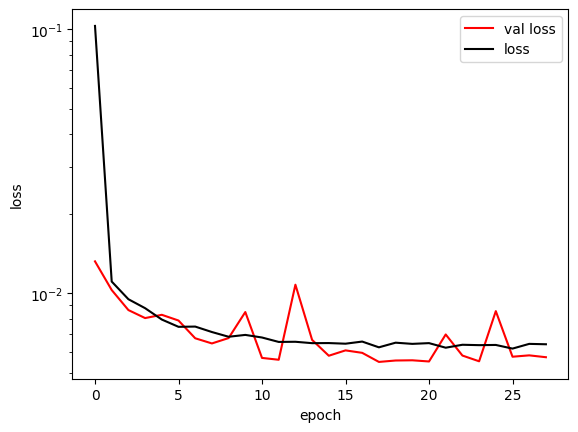

In [88]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()

Is the model still learning? Are both the loss and val_loss decreasing? When should we stop training?

In [87]:
# let's add a stopping criteria
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = get_compiled_model()
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=100,batch_size=128,shuffle=True,callbacks=[callback])

Epoch 1/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4678 - val_loss: 0.0132
Epoch 2/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0118 - val_loss: 0.0103
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0100 - val_loss: 0.0086
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 8/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 9/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 10/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0069 - val_loss: 0.0085
Epoch 11/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 12/100
598/598 ━━━━━━━━━━━━━━━━━━━━

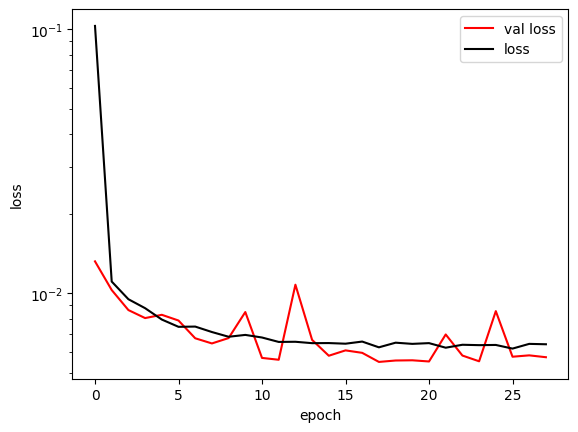

In [89]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend()

1994/1994 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


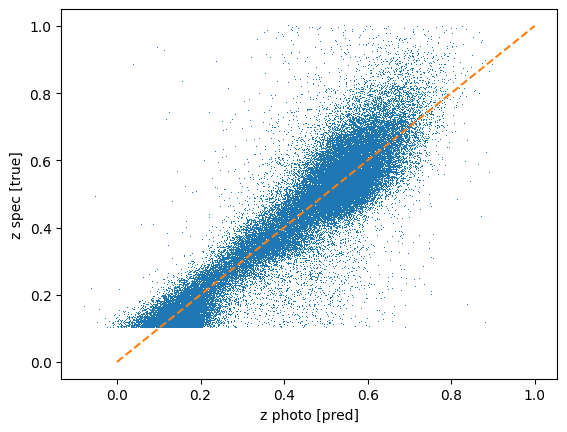

In [90]:
pred=model.predict(x_test).squeeze()

plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()

dispersion:  0.05263898


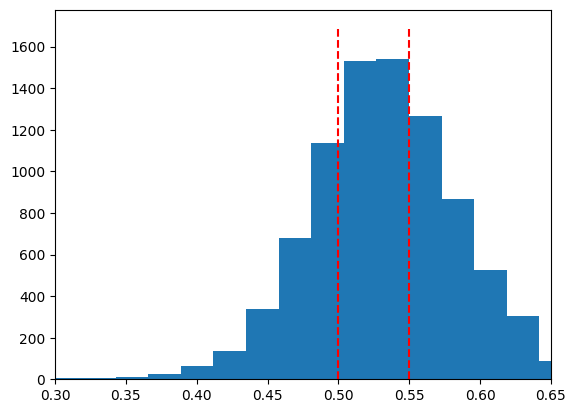

In [95]:
specz=[0.5,0.55]
a=plt.hist(pred[(y_test>specz[0]) & (y_test<specz[1])],30)
plt.plot([specz[0],specz[0]],[0,1.1*np.max(a[0])],'r--')
plt.plot([specz[1],specz[1]],[0,1.1*np.max(a[0])],'r--')
plt.xlim((0.3,0.65))

print('dispersion: ',np.std(pred[(y_test>specz[0]) & (y_test<specz[1])]))

Sometimes the best model (lowest val_loss) is not the last epoch. So lets restore the weights of the model with the lowest val_loss.

In [93]:
# let's save and restore the best model
call_save = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.weights.h5',
                                              save_weights_only=True,
                                              monitor='val_loss',
                                              mode='min',
                                              save_best_only=True)

model = get_compiled_model()
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=100,batch_size=128,shuffle=True,callbacks=[callback, call_save])

Epoch 1/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0967 - val_loss: 0.0097
Epoch 2/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0095 - val_loss: 0.0103
Epoch 3/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0083 - val_loss: 0.0072
Epoch 4/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0076 - val_loss: 0.0092
Epoch 5/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 6/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 7/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 9/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 10/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 11/100
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 12/100
598/598 ━━━━━━━━━━━━━━━━━━━━

1994/1994 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


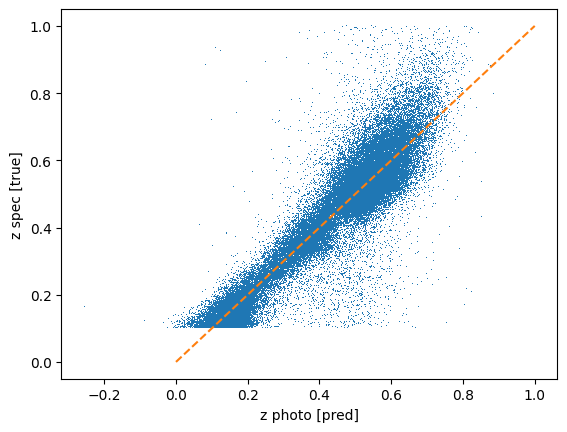

In [94]:
# now restore the best model before prediction
model.load_weights('best_model.weights.h5')

pred=model.predict(x_test).squeeze()

plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()


Assignment 3:


*   Try different # layers and/or neurons
*   What is the best val_loss you can get
*   What is the lowest dispersion on for 0.5< spec z < 0.55

